In [52]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import treelib
from treelib import Node, Tree
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [2]:
data=pd.read_csv("house-votes-84.csv")

In [3]:
data.head()

,Class Name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [4]:
originalColumnNames=list(data.columns)

#### Rename Colunms

In [5]:
Columns={}
index=0
for col in list(data.columns):
    Columns[col]="f"+str(index)
    index+=1
data=data.rename(columns=Columns)

#### Add Label Column

In [ ]:
def getLabel(Class):
    if Class=="democrat":
        return 1
    else:
        return 0

In [7]:
data["Label"]=data.f0.apply(lambda x: 1 if x=='democrat' else 0)

In [9]:
data=data.drop(columns=['f0'])

In [10]:
data.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,Label
0,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y,0
1,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?,0
2,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n,1
3,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y,1
4,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y,1


### An Interesting Imputation Problem

The data set has many question marks, apparently when the congressmember did not vote on a particular bill.  Since this project is more about creating the tree, I chose to replace "?" with the majority vote within the party that a particular congressmember resides.

I do not think that this is the best possible imputation strategy, since there are some bills that do not have a strict party line vote.  A good example of this is the mx-missle bill.

In [11]:
republicans=data[data["Label"]==0]
democrats=data[data["Label"]==1]

In [12]:
print(originalColumnNames[9])
print("repubs")
print(republicans["f10"].value_counts())
print("dems")
print(democrats["f10"].value_counts())

 mx-missile
repubs
y    92
n    73
?     3
Name: f10, dtype: int64
dems
n    139
y    124
?      4
Name: f10, dtype: int64


In [17]:
demImputer = SimpleImputer(missing_values="?", strategy='most_frequent')
repImputer = SimpleImputer(missing_values="?", strategy='most_frequent')

In [18]:
demImputer.fit(democrats)
repImputer.fit(republicans)

SimpleImputer(missing_values='?', strategy='most_frequent')

In [19]:
democrats=pd.DataFrame(demImputer.transform(democrats), columns=democrats.columns)
republicans=pd.DataFrame(repImputer.transform(republicans), columns=republicans.columns)

In [37]:
data=pd.concat([republicans, democrats], ignore_index=True)
data=data.sample(n=435, replace=False).reset_index().drop(columns={"index"})

### Train Test Split

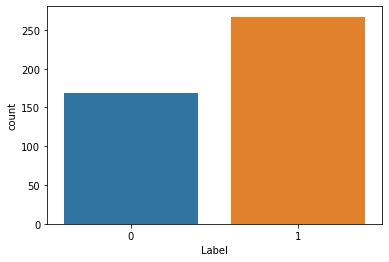

In [27]:
ax = sns.countplot(x="Label", data=data)

In [29]:
rng=np.random.RandomState(2021111)

#Slect the test data.
test=data.sample(frac=0.25, random_state=rng)

#Create boolean mask.
train_mask=pd.Series(True, index=data.index)

train_mask[test.index] = False

train = data[train_mask].copy()

## The Decision Tree

#### Preliminary Functions

In [21]:
def impurity(df, feature, value): # df is a dataframe, feature is the feature name as a string, value is boolean
    if len(df[df[feature]==value])==0:
        return 1
    else:
        return 1-(len(df[(df[feature]==value) & (df["Label"]==0)])/len(df[df[feature]==value]))**2-(len(df[(df[feature]==value) & (df["Label"]==1)])/len(df[df[feature]==value]))**2

In [22]:
def weightedImpurity(df, feature):
    return (len(df[df[feature]=="n"])/len(df))*impurity(df, feature, "n")+(len(df[df[feature]=="y"])/len(df))*impurity(df, feature, "y")

In [23]:
def purestFeature(df, labelColumnName, columnName):
    # Grab features that are not label
    features=set(df.columns).difference(set([labelColumnName, columnName]))
    # create dict with weighted impurity key and feature value
    featureImpurities={}
    for feature in features:
        featureImpurities[weightedImpurity(df, feature)]=feature
        
    return featureImpurities[np.array(list(featureImpurities.keys())).min()]

In [24]:
def isPure(df, labelColumnName):
    if (len(df)==df[labelColumnName].sum()) or (df[labelColumnName].sum()==0):
        return True
    else:
        return False

In [25]:
def value(df, labelColumnName):
    if not(isPure(df,labelColumnName)): # not pure
        num_ones=len(df[df[labelColumnName]==1])
        num_zeros=len(df[df[labelColumnName]==0])
        if max(num_ones,num_zeros)==num_ones:
            return 1
        else:
            return 0
    else: # pure
        return df.reset_index()[labelColumnName][0]

In [26]:
def unreconcilable(df): # needs to be generalized for any df
    numFeaturesAllOneValue=0
    features=set(df.columns).difference(set(["Label"]))
    for feature in features:
        if (len(df[df[feature]=="y"])==0) or (len(df[df[feature]=="n"])==0):
            numFeaturesAllOneValue+=1
    if numFeaturesAllOneValue==len(features):
        return True
    else:
        return False

### Fit

In [31]:
def Fit(df): # assuming df does not start as pure
    tree=Tree()
    maxDepth=16 # will need to generalize 
    tree.create_node(purestFeature(df, "Label", "A"), "0", data=df)
    while tree.depth() <= maxDepth:
        numTerminalLeaves=0
        print(tree.leaves())
        for leaf in tree.leaves():
            DF=leaf.data
            if type(leaf.tag)==type("aa"):
                left=DF[DF[leaf.tag]=="y"]
                if isPure(left,"Label") or unreconcilable(left): # if left is terminal
                    tree.create_node(value(left, "Label"), leaf.identifier+"y",parent=leaf.identifier)  #leaf.identifier+"A"                  
                else:
                    tree.create_node(purestFeature(left, "Label", leaf.tag), leaf.identifier+"y",parent=leaf.identifier, data=left)
                
                # now do the same for right 
                right=DF[DF[leaf.tag]=="n"]
                if isPure(right,"Label") or unreconcilable(right): # if right is terminal
                    tree.create_node(value(right, "Label"), leaf.identifier+"n",parent=leaf.identifier)
                else:
                    tree.create_node(purestFeature(right, "Label", leaf.tag), leaf.identifier+"n", parent=leaf.identifier, data=right)
                
            else:
                numTerminalLeaves+=1
            # check to see if all leaves terminal
        if numTerminalLeaves==len(tree.leaves()):
            break
        continue
    return tree

#### Fit the Training Data

In [30]:
feature_columns=list(data.columns)
feature_columns.remove("Label")

It is interesting to see the data that is stored in each leaf as the tree is built.  Note that the identifier for each node gives a traversal from the root node labelled "0" to a that particular node.

In [32]:
T=Fit(train)

[Node(tag=f4, identifier=0, data=    f1 f2 f3 f4 f5 f6 f7 f8 f9 f10 f11 f12 f13 f14 f15 f16 Label
0    n  y  n  y  y  y  n  n  n   y   n   y   y   y   n   y     0
2    n  y  n  y  y  y  n  n  n   n   n   n   y   y   n   y     0
4    n  y  n  y  y  n  n  n  n   n   n   y   y   y   n   n     0
5    n  y  n  y  y  y  n  n  n   n   y   y   y   y   n   y     0
7    n  y  n  y  y  y  n  n  n   y   n   y   y   y   n   y     0
..  .. .. .. .. .. .. .. .. ..  ..  ..  ..  ..  ..  ..  ..   ...
428  n  y  y  n  n  y  y  y  y   n   y   n   n   y   y   y     1
430  n  n  y  n  n  n  y  y  n   y   y   n   n   n   y   y     1
431  y  n  y  n  n  n  y  y  y   y   n   n   n   n   y   y     1
432  y  y  y  n  n  n  y  y  y   y   n   n   y   n   y   y     1
434  n  n  y  n  n  n  y  y  y   y   n   n   n   n   n   y     1

[326 rows x 17 columns])]
[Node(tag=f11, identifier=0y, data=    f1 f2 f3 f4 f5 f6 f7 f8 f9 f10 f11 f12 f13 f14 f15 f16 Label
0    n  y  n  y  y  y  n  n  n   y   n   y   y   y   n   y  

### Predict

My evaluate function iteratively builds the identifier for the leaf node that contains the predicted label for a particular observation.

In [61]:
def evaluate(tree, df, rowIndex):
    id="0"
    while type(tree.get_node(id).tag)==type("aa"):
        id+=df.iloc[rowIndex][tree.get_node(id).tag]
    
    return tree.get_node(id).tag

In [62]:
def Predict(tree, df):
    predList=[]
    for rowIndex in df.index:
        predList.append(evaluate(tree, df, rowIndex))    
    return np.array(predList)

In [63]:
y_pred=Predict(T, test)
y_test=test["Label"].to_numpy()

### Accuracy

In [64]:
(y_pred==y_test).sum()/len(y_test)

0.9357798165137615

## Sci-Kit Learn's Decision Tree

#### Convert "y" and "n" to 1 and 0 

In [53]:
ordEncoder=OrdinalEncoder()
ordEncoder.fit(data)

OrdinalEncoder()

In [54]:
data=pd.DataFrame(ordEncoder.transform(data), columns=data.columns)

In [55]:
feature_columns=list(data.columns)
feature_columns.remove("Label")
X=data[feature_columns]
y=data.Label

In [56]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.25, random_state=25)

In [57]:
decisionTree=DecisionTreeClassifier()

In [58]:
decisionTree.fit(X_train, y_train)

DecisionTreeClassifier()

In [59]:
y_pred=decisionTree.predict(X_test)

#### Accuracy

In [60]:
(y_pred==y_test).sum()/len(y_test)

0.9541284403669725